In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None 

### DECISION TREE CLASS CREATION

-----


In [2]:
class Decision_tree():

    def __init__(self, dataframe, response_variable):

        self.dataframe = dataframe
        self.response_variable = response_variable


    def _print_tree(self, the_tree):

        plt.figure(figsize = (40, 20))
        tree.plot_tree(the_tree, feature_names = self.feat_names, filled = True)
        plt.show()
        
        
    def fit_model(self):

        X = self.dataframe.drop(self.response_variable, axis = 1)
        y = self.dataframe[self.response_variable]

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

        my_tree = DecisionTreeClassifier(random_state =0)

        my_tree.fit(self.x_train, self.y_train)
        
        self.feat_names = list(self.x_train.columns)

        self._print_tree(my_tree)

        self.y_pred_test = my_tree.predict(self.x_test)
        self.y_pred_train = my_tree.predict(self.x_train)

        dicc_params = {'max_features': np.sqrt(len(self.x_train.columns)), 'max_depth': my_tree.tree_.max_depth}

        return dicc_params
    

    def get_metrics(self, model_name):
        
        accuracy_test = accuracy_score(self.y_test, self.y_pred_test)
        precision_test = precision_score(self.y_test, self.y_pred_test)
        recall_test = recall_score(self.y_test, self.y_pred_test)
        f1_test = f1_score(self.y_test, self.y_pred_test)
        kappa_test = cohen_kappa_score(self.y_test, self.y_pred_test)

        accuracy_train = accuracy_score(self.y_train, self.y_pred_train)
        precision_train = precision_score(self.y_train, self.y_pred_train)
        recall_train = recall_score(self.y_train, self.y_pred_train)
        f1_train = f1_score(self.y_train, self.y_pred_train)
        kappa_train = cohen_kappa_score(self.y_train, self.y_pred_train)
            
        dataframe = pd.DataFrame({'accuracy': [accuracy_test, accuracy_train], 
                            'precision': [precision_test, precision_train],
                            'recall': [recall_test, recall_train], 
                            'f1': [f1_test, f1_train],
                            'kappa': [kappa_test, kappa_train],
                            'set': ['test', 'train']})
        
        dataframe['model'] = model_name

        return dataframe
    

    def define_best_model(self, parameters):

        grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state= 42), param_grid= parameters, cv=10, verbose= False) 

        grid_search.fit(self.x_train, self.y_train)

        self.best_tree = grid_search.best_estimator_

        self._print_tree(self.best_tree)

        return self.best_tree


    def apply_best_model(self, model_name):

        self.y_pred_test = self.best_tree.predict(self.x_test)
        self.y_pred_train = self.best_tree.predict(self.x_train)

        best_results_dataframe = self.get_metrics(model_name)

        return best_results_dataframe 


    def create_df_feature_importance(self):

        self.predictors_sig_dataframe = pd.DataFrame({'predictor': self.x_train.columns, 'importance': self.best_tree.feature_importances_})

        self.predictors_sig_dataframe.sort_values(by=['importance'], ascending=False, inplace = True)

        return self.predictors_sig_dataframe
        

    def create_barplot_feature_importance(self, title_dataframe):

        my_barplot_palette = LinearSegmentedColormap.from_list('Gradient', ['teal', 'mediumturquoise', 'paleturquoise'])
        num_bars = (len(self.dataframe.columns) -1)

        plt.figure(figsize=(10,6))
        sns.barplot(x = 'importance', y = 'predictor', data = self.predictors_sig_dataframe, palette= my_barplot_palette(np.linspace(0, 1, num_bars)))
        plt.title(f'{title_dataframe.upper()} DECISION TREE FEATURE IMPORTANCE', fontsize = 12, color = 'darkslategray', fontweight = 'bold')
        plt.show()


### DECISION TREE ON RANDOM_OVER_SAMPLE DATAFRAME

-----


In [3]:
df_over = pd.read_pickle('../data/cardio_processed_over.pkl')
df_over.head()

,age_category,BMI_category,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,education_1.0,education_2.0,education_3.0,education_4.0,sex_F,sex_M,is_smoking_NO,is_smoking_YES,TenYearCHD
0,2.0,0.25,0,0,0,0,1.071429,0.15,-0.224138,0.722222,0.450931,1.000000,0.142857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,0.5,0.25,0,0,1,0,-0.928571,0.00,-0.379310,1.462963,0.883744,-0.200000,-0.214286,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
2,0.5,0.00,0,0,0,0,-0.214286,0.50,0.275862,-0.462963,-1.012582,0.866667,1.142857,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,0.5,0.25,0,0,1,0,0.071429,1.00,-0.017241,1.092593,0.579768,-0.466667,1.142857,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
4,2.0,0.25,0,0,0,0,1.071429,1.50,0.120690,0.296296,0.209361,-0.333333,-0.071429,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [4]:
response_var = 'TenYearCHD'

In [5]:
decision_tree_over = Decision_tree(df_over, response_var)

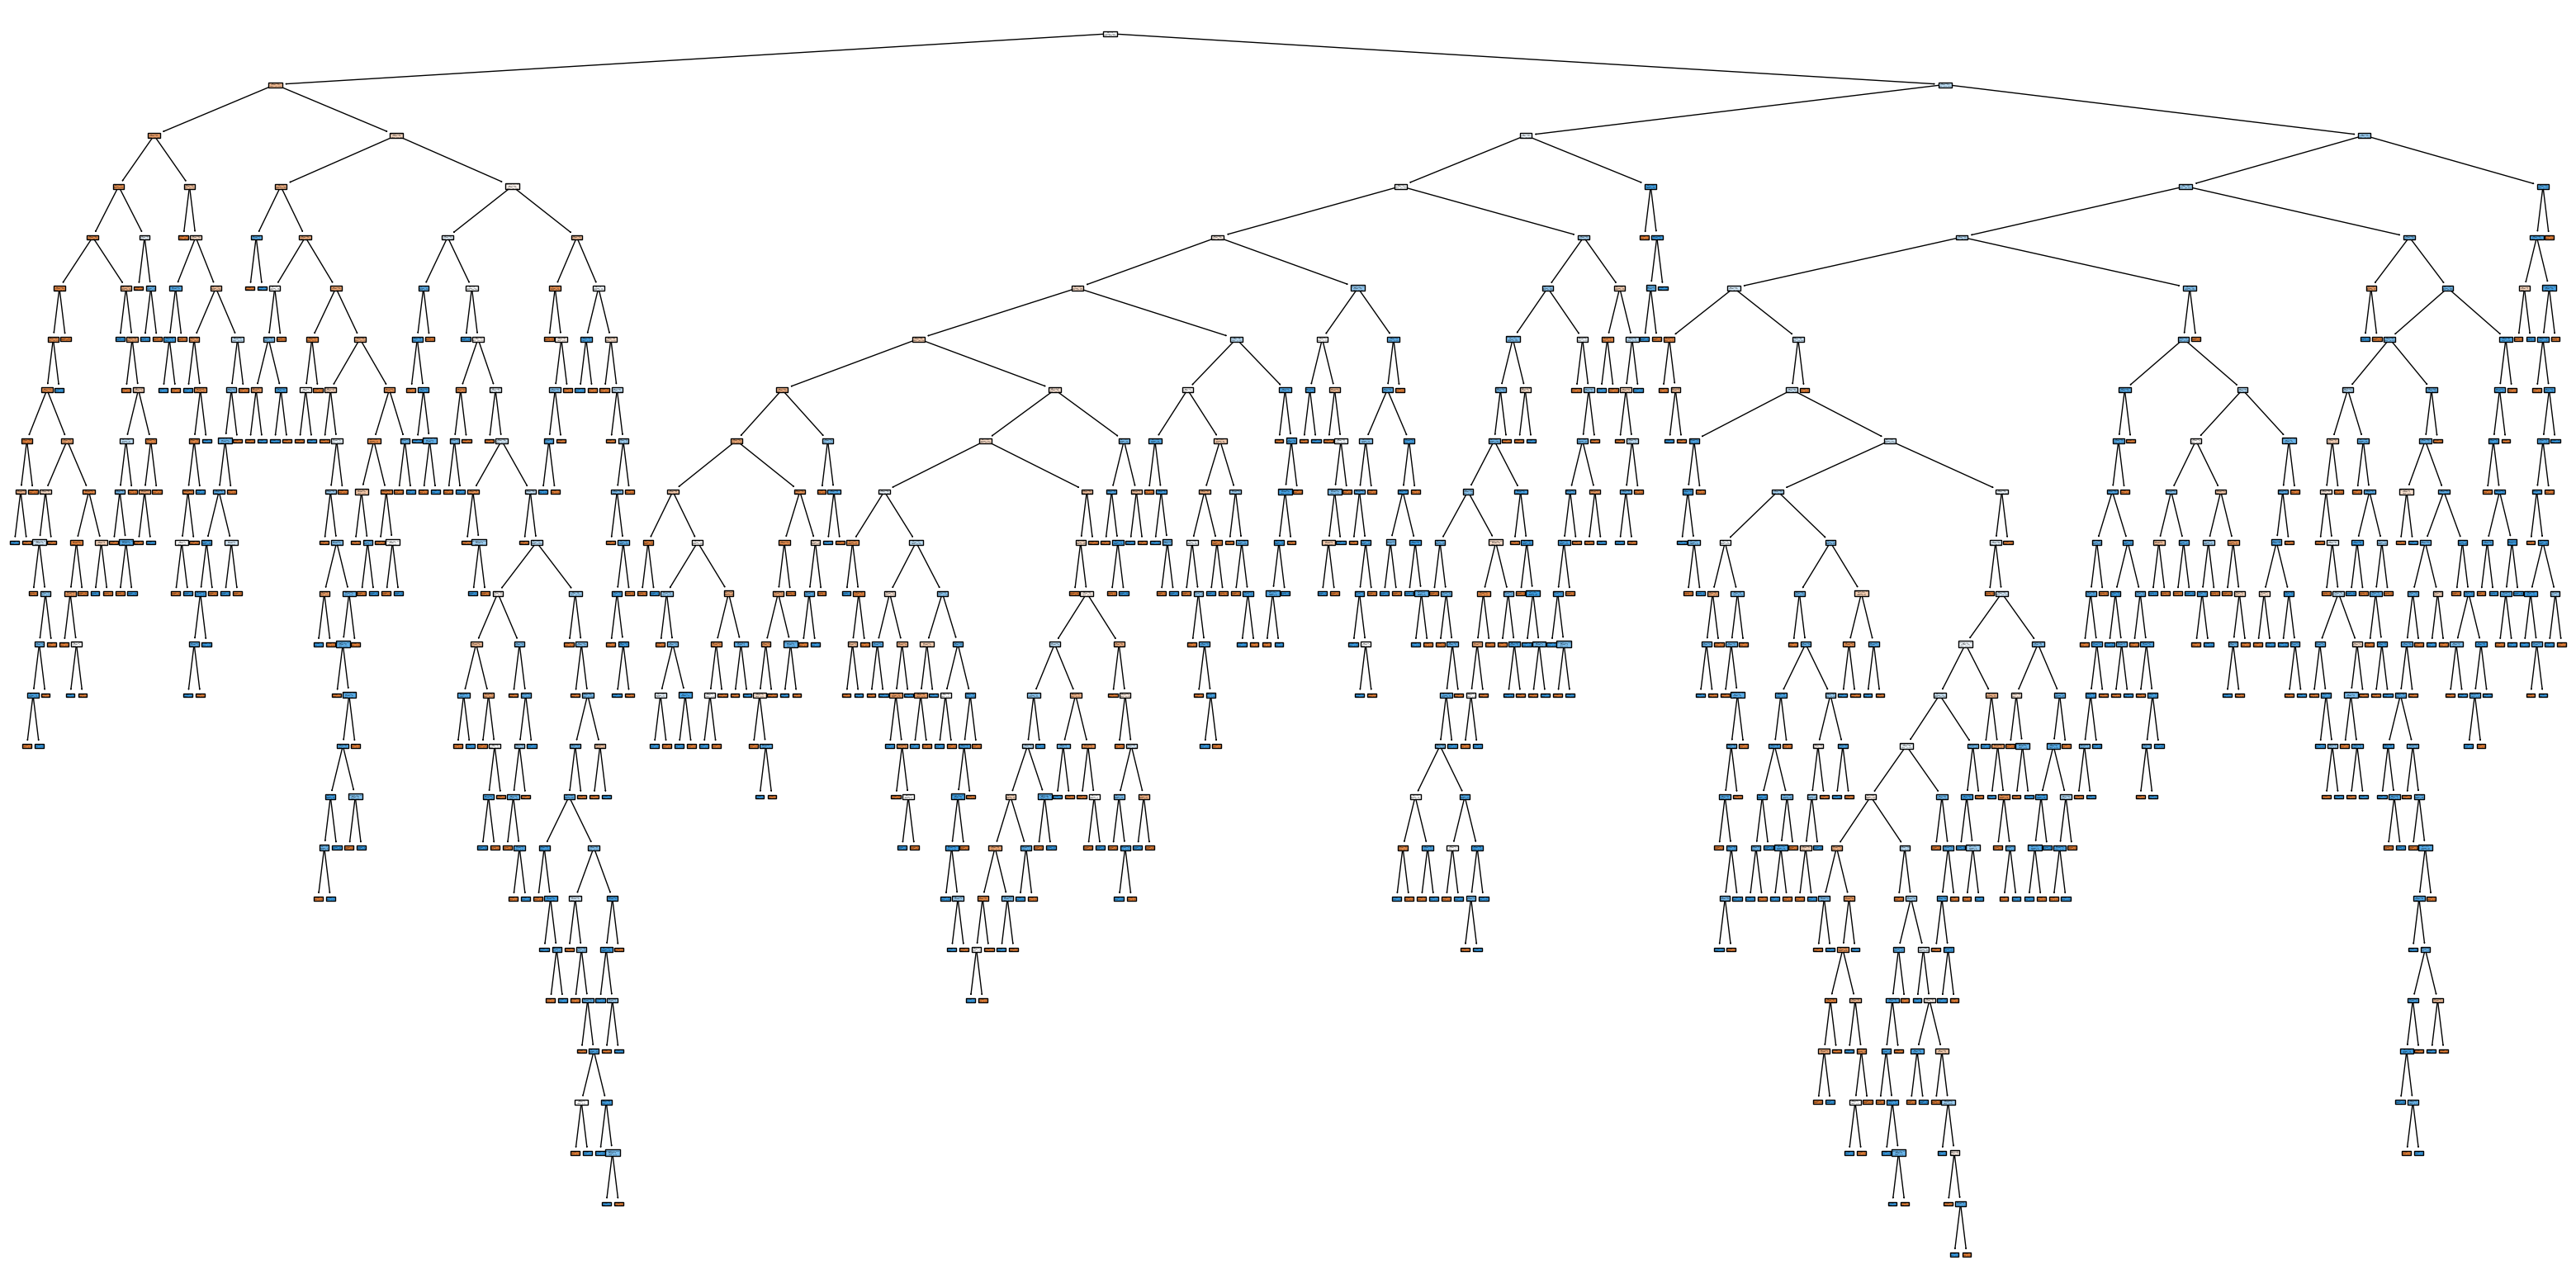

{'max_features': 4.58257569495584, 'max_depth': 24}

In [6]:
decision_tree_over.fit_model()

In [7]:
decision_tree_over.get_metrics('OVER Decision Tree')

,accuracy,precision,recall,f1,kappa,set,model
0,0.895833,0.837755,0.975059,0.901207,0.792376,test,OVER Decision Tree
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,OVER Decision Tree


In [8]:
param_over = {"max_depth": [9, 10, 11, 12], 
        "max_features": [2, 3, 4, 5],
        "min_samples_split": [50, 100, 150],
        "min_samples_leaf": [10, 20, 50]} 

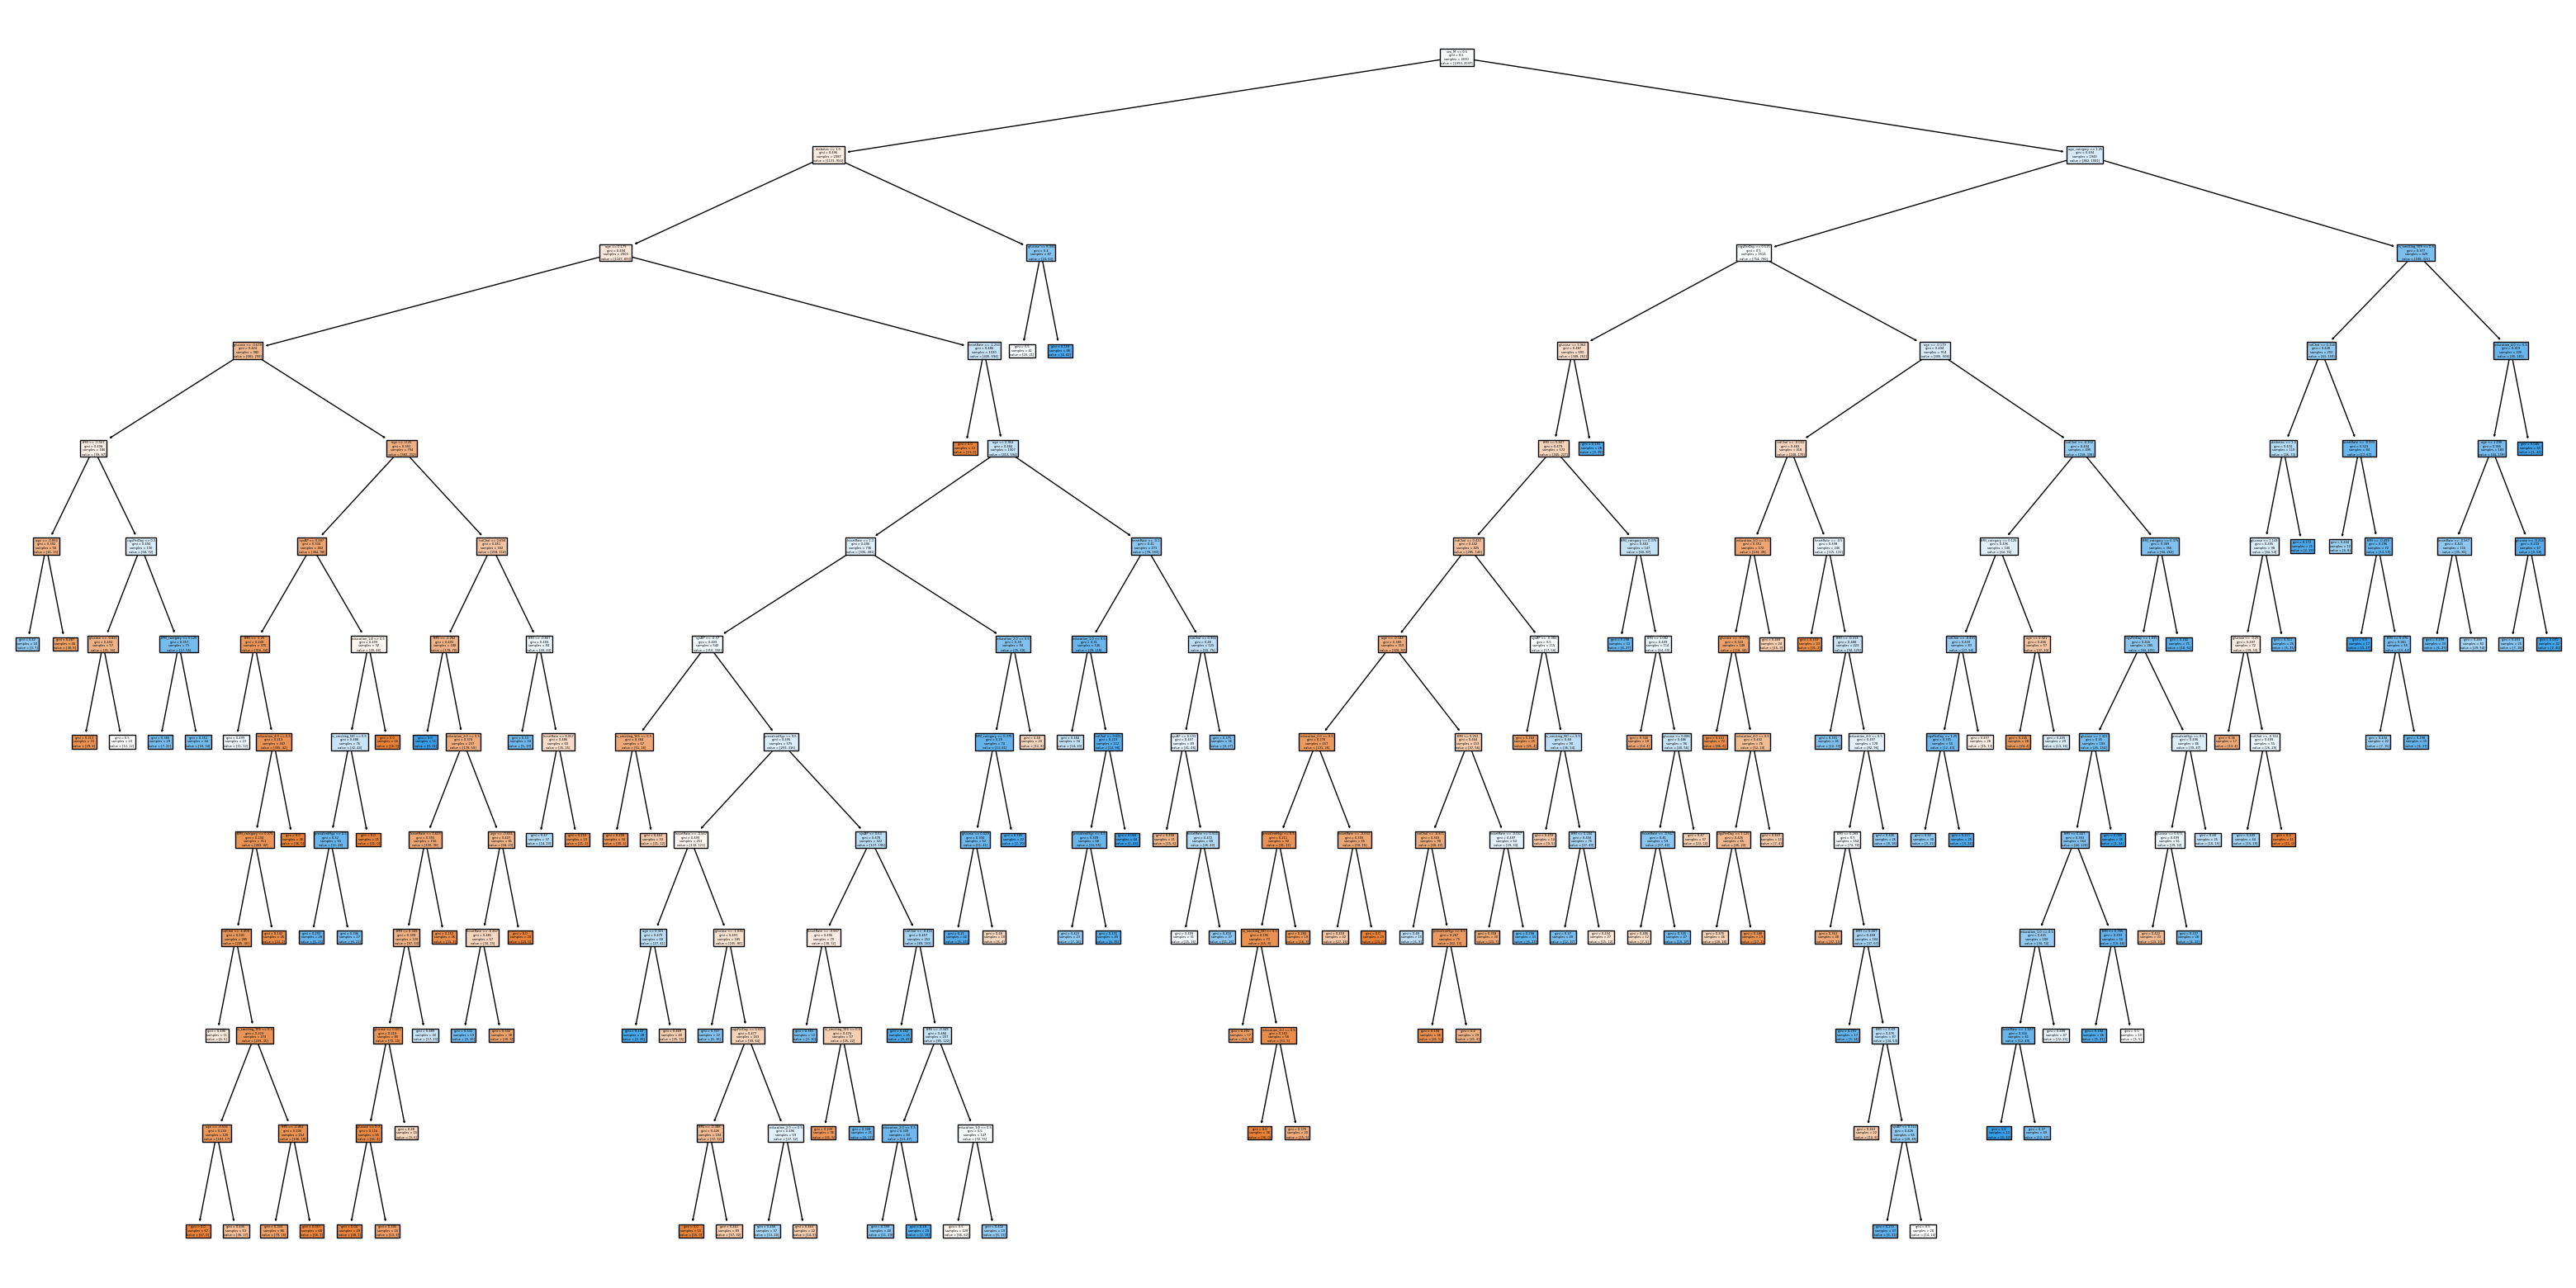

DecisionTreeClassifier(max_depth=12, max_features=4, min_samples_leaf=10,
                       min_samples_split=50, random_state=42)

In [9]:
decision_tree_over.define_best_model(param_over)

In [10]:
dt_over_results = decision_tree_over.apply_best_model('OVER Decision Tree Best')
dt_over_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.710648,0.693002,0.729216,0.710648,0.421671,test,OVER Decision Tree Best
1,0.771960,0.770571,0.781541,0.776018,0.543795,train,OVER Decision Tree Best


In [11]:
decision_tree_over.create_df_feature_importance()

,predictor,importance
6,age,0.219416
10,BMI,0.137919
11,heartRate,0.102262
8,totChol,0.099495
12,glucose,0.098710
9,sysBP,0.060648
7,cigsPerDay,0.054641
0,age_category,0.052821
19,is_smoking_NO,0.028147
18,sex_M,0.025323


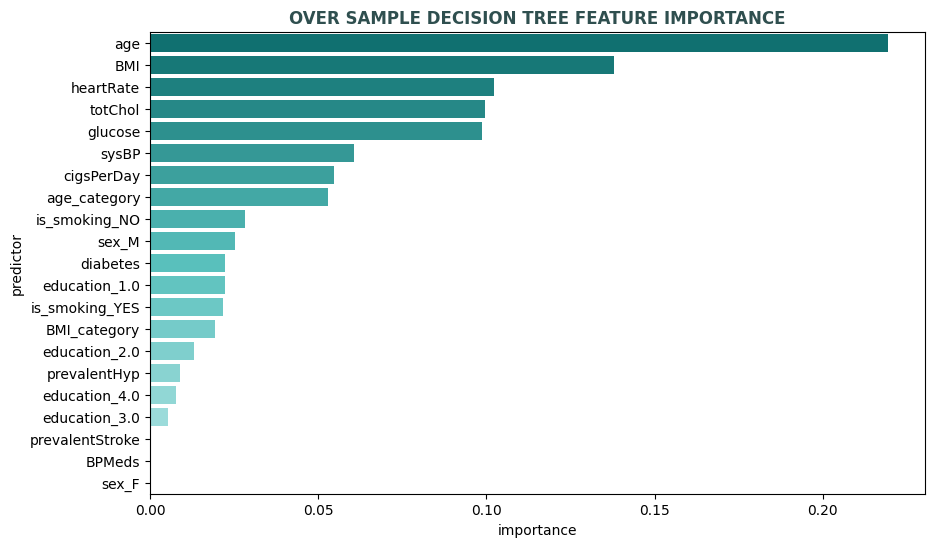

In [12]:
decision_tree_over.create_barplot_feature_importance('OVER SAMPLE')

### DECISION TREE ON TOKEN_SMOTE DATAFRAME

-----


In [13]:
df_ts = pd.read_pickle('../data/cardio_processed_ts.pkl')
df_ts.head()

,age_category,BMI_category,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,TenYearCHD,education_1.0,education_2.0,education_3.0,education_4.0,sex_F,sex_M,is_smoking_NO,is_smoking_YES
0,2.0,0.25,0,0,0,0,1.071429,0.15,-0.224138,0.722222,0.450931,1.000000,0.142857,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.5,0.25,0,0,1,0,-0.928571,0.00,-0.379310,1.462963,0.883744,-0.200000,-0.214286,0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.5,0.00,0,0,0,0,-0.214286,0.50,0.275862,-0.462963,-1.012582,0.866667,1.142857,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.5,0.25,0,0,1,0,0.071429,1.00,-0.017241,1.092593,0.579768,-0.466667,1.142857,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2.0,0.25,0,0,0,0,1.071429,1.50,0.120690,0.296296,0.209361,-0.333333,-0.071429,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [14]:
decision_tree_ts = Decision_tree(df_ts, response_var)

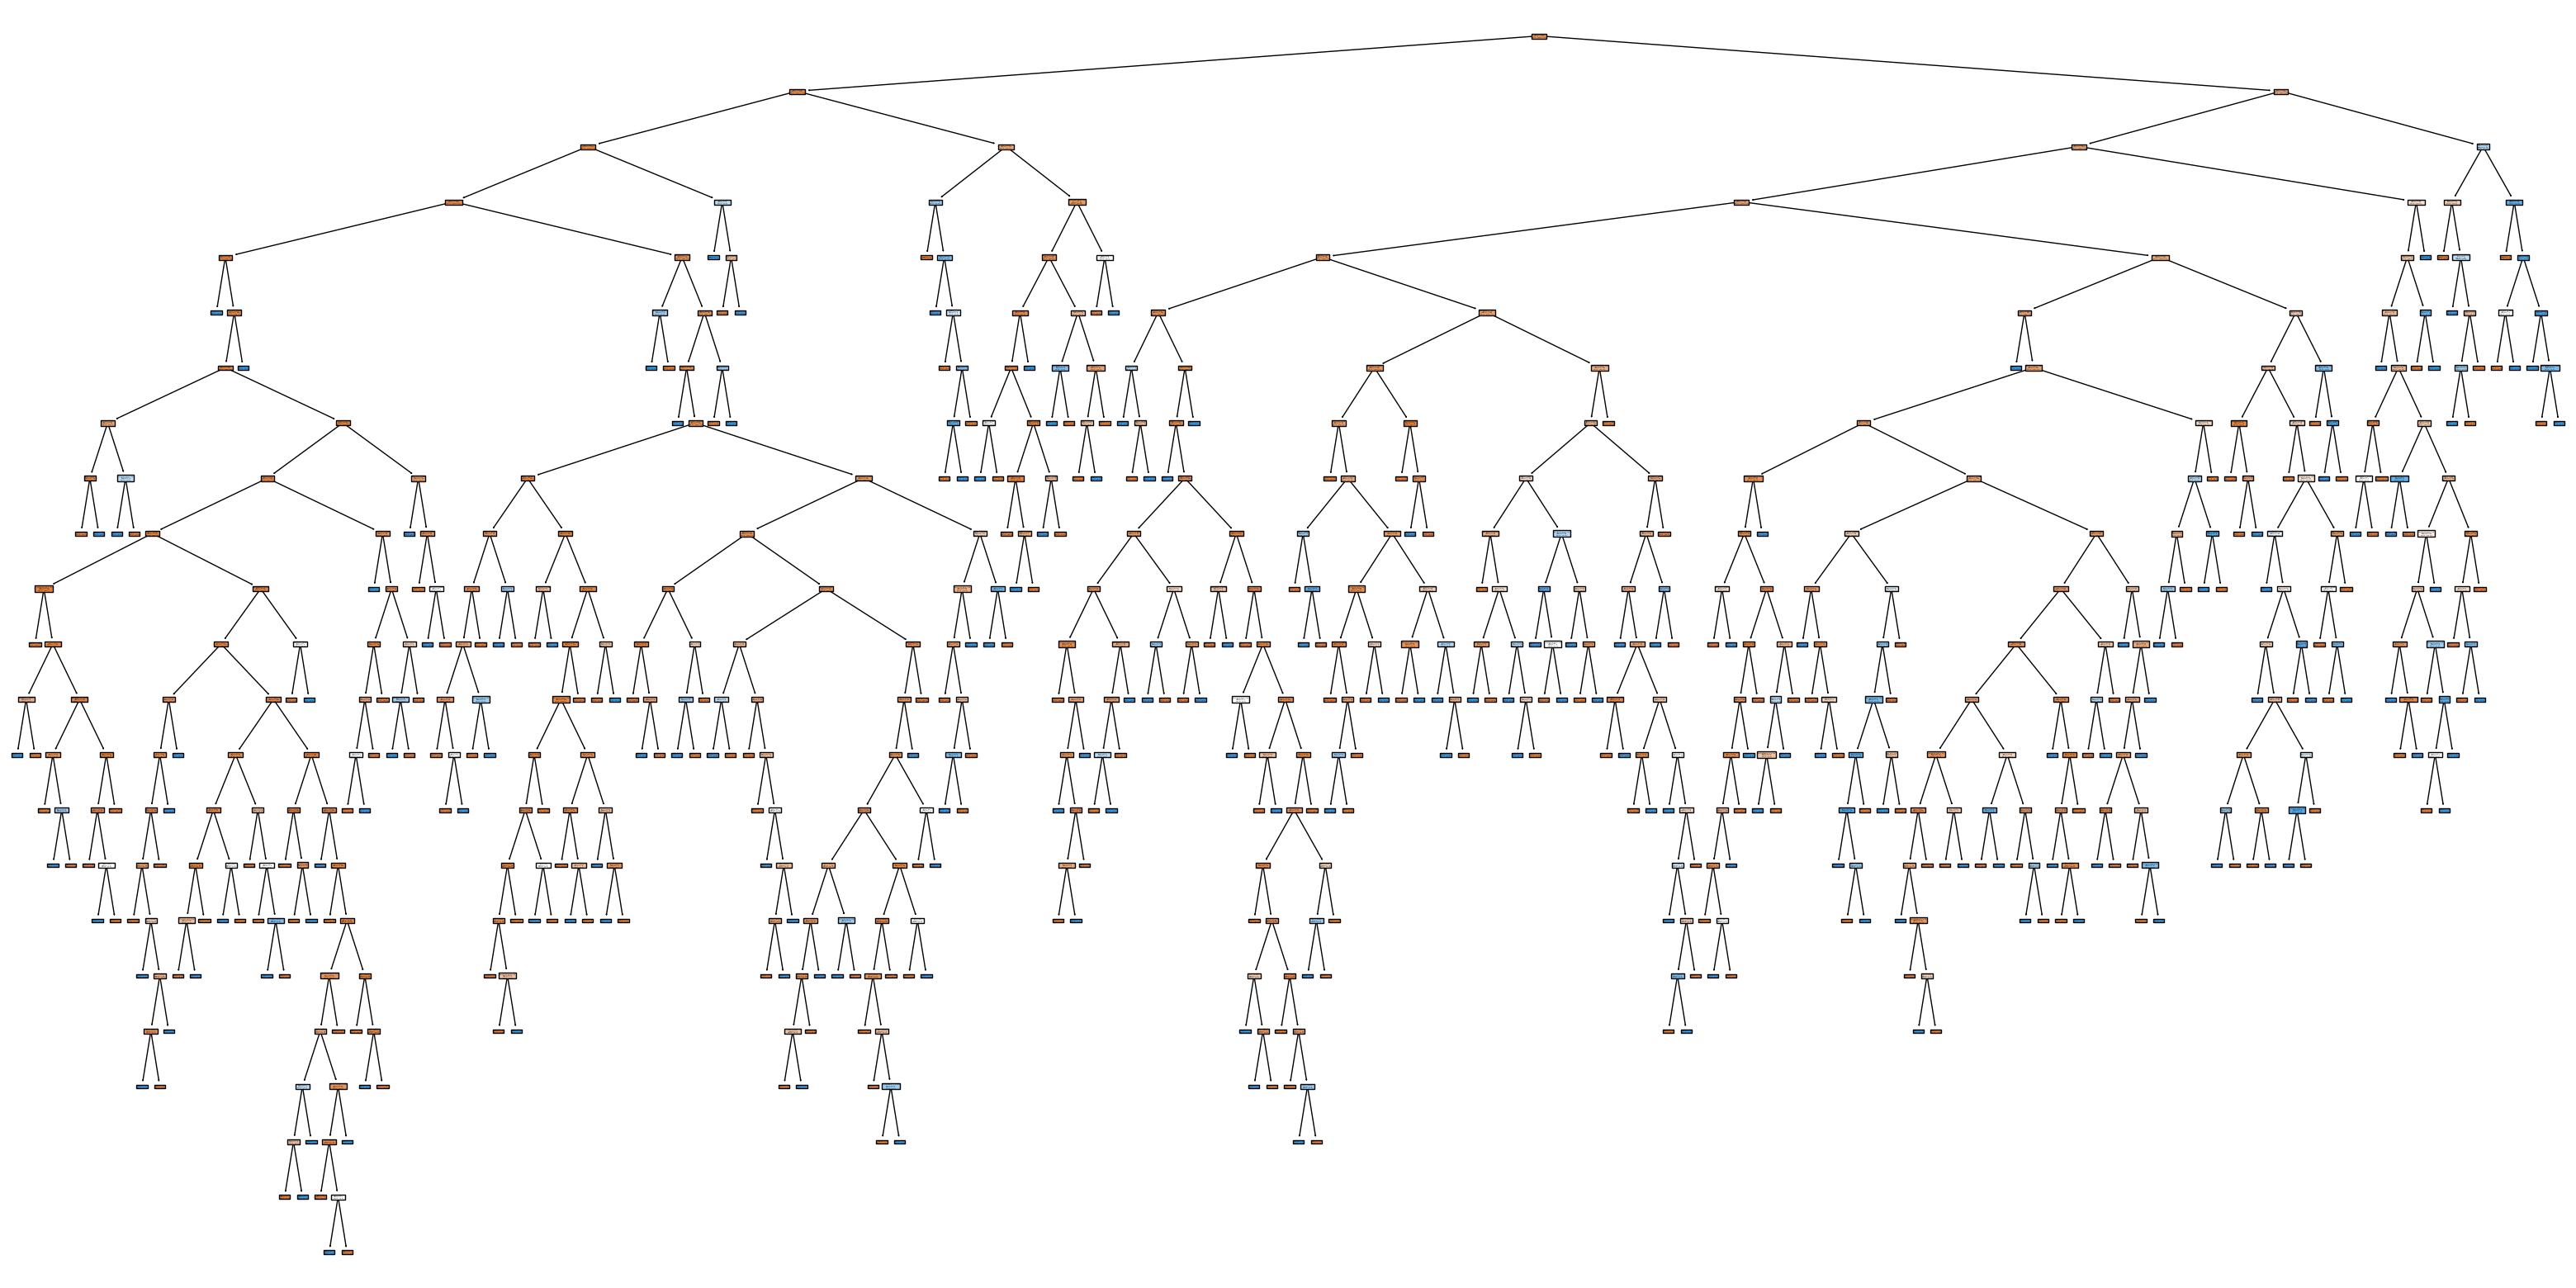

{'max_features': 4.58257569495584, 'max_depth': 22}

In [15]:
decision_tree_ts.fit_model()

In [16]:
decision_tree_ts.get_metrics('TS Decision Tree')

,accuracy,precision,recall,f1,kappa,set,model
0,0.765978,0.256831,0.315436,0.283133,0.145046,test,TS Decision Tree
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,TS Decision Tree


In [41]:
param_ts = {"max_depth": [10, 11, 12], 
        "max_features": [3, 4, 5],
        "min_samples_split": [50, 100, 150],
        "min_samples_leaf": [10, 20, 50]} 

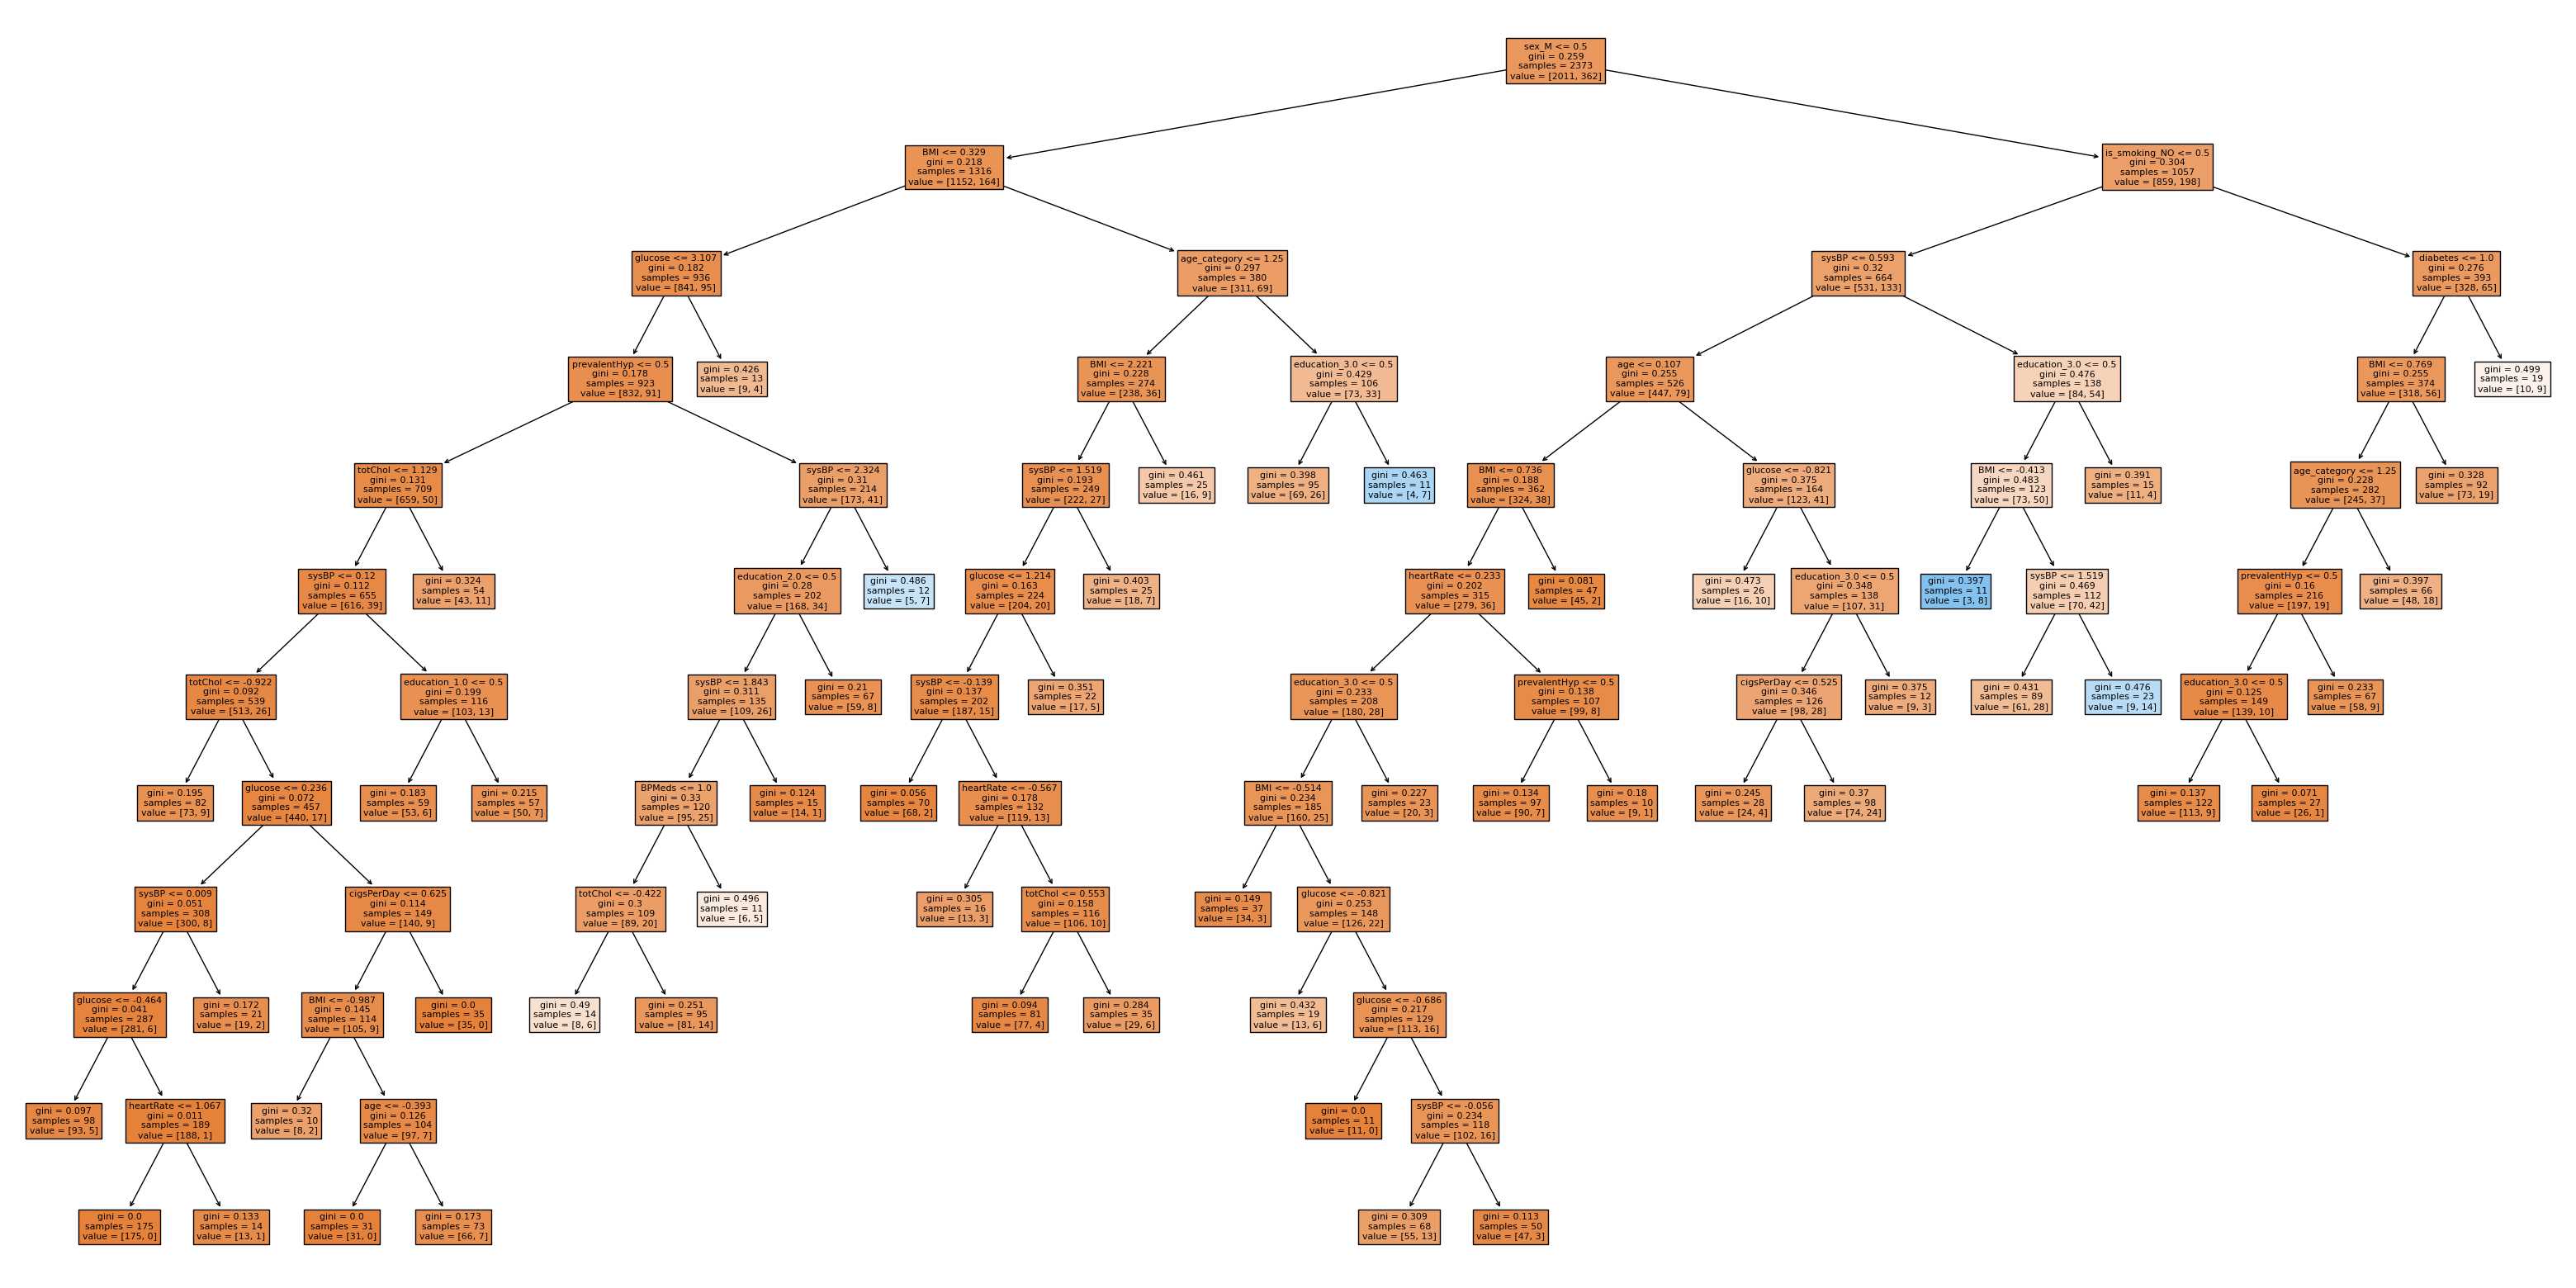

DecisionTreeClassifier(max_depth=11, max_features=3, min_samples_leaf=10,
                       min_samples_split=100, random_state=42)

In [42]:
decision_tree_ts.define_best_model(param_ts)

In [43]:
dt_ts_results = decision_tree_ts.apply_best_model('TS Decision Tree Best')
dt_ts_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.852507,0.473684,0.060403,0.107143,0.076540,test,TS Decision Tree Best
1,0.853772,0.631579,0.099448,0.171838,0.135976,train,TS Decision Tree Best


In [44]:
decision_tree_ts.create_df_feature_importance()

,predictor,importance
9,sysBP,0.303129
10,BMI,0.132148
0,age_category,0.104457
8,totChol,0.067934
12,glucose,0.065477
4,prevalentHyp,0.065286
6,age,0.064012
18,sex_M,0.057314
5,diabetes,0.047190
15,education_3.0,0.039713


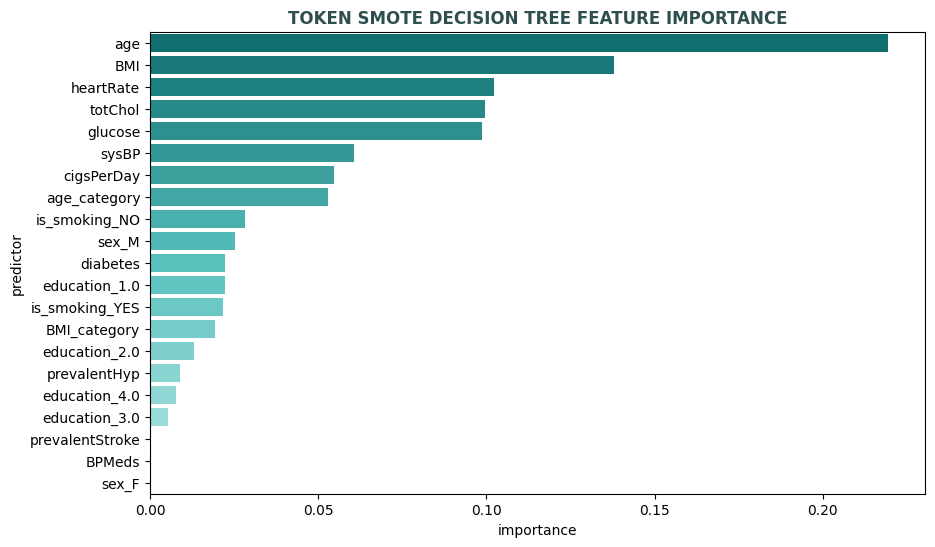

In [45]:
decision_tree_over.create_barplot_feature_importance('token smote')

### SAVE RESULTS

-----


In [46]:
lr_results = pd.read_pickle('../data/LR_results.pkl')
lr_results.head()

,accuracy,precision,recall,f1,kappa,set,model
0,0.687500,0.675174,0.691211,0.683099,0.374963,test,OVER Logistic Regression
1,0.654342,0.655556,0.666176,0.660823,0.308479,train,OVER Logistic Regression
0,0.860374,0.684211,0.087248,0.154762,0.125791,test,TS Logistic Regression
1,0.856300,0.744186,0.088398,0.158025,0.129837,train,TS Logistic Regression


In [47]:
all_results = pd.concat([lr_results, dt_over_results, dt_ts_results], axis = 0)
all_results

,accuracy,precision,recall,f1,kappa,set,model
0,0.687500,0.675174,0.691211,0.683099,0.374963,test,OVER Logistic Regression
1,0.654342,0.655556,0.666176,0.660823,0.308479,train,OVER Logistic Regression
0,0.860374,0.684211,0.087248,0.154762,0.125791,test,TS Logistic Regression
1,0.856300,0.744186,0.088398,0.158025,0.129837,train,TS Logistic Regression
0,0.710648,0.693002,0.729216,0.710648,0.421671,test,OVER Decision Tree Best
1,0.771960,0.770571,0.781541,0.776018,0.543795,train,OVER Decision Tree Best
0,0.852507,0.473684,0.060403,0.107143,0.076540,test,TS Decision Tree Best
1,0.853772,0.631579,0.099448,0.171838,0.135976,train,TS Decision Tree Best


In [48]:
all_results.to_pickle('../data/LR_DT_results.pkl')